In [1]:
import nilearn
from nilearn import plotting
from nilearn import datasets
from nilearn import image
from nilearn.image import mean_img
from nilearn.datasets import MNI152_FILE_PATH

import numpy as np
import pandas as pd

from nilearn.image import mean_img,math_img,index_img,concat_imgs
import warnings
warnings.filterwarnings('ignore')

C:\Users\Asus\AppData\Roaming\Python\Python38\site-packages\nilearn\datasets\__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Averiguação da shape do dataset e importação do mesmo

In [11]:
import os
import nibabel as nib
n_subjects=2
n_sessions=1
n_runs=3
sub='sub-000%d' %n_subjects
ses='ses-00%d' %n_sessions
bs_maps=None
path='C:\\Users\\Asus\\Documents\\3oAno\\Estágio\\Dados'

fmri_img=os.path.join('bs_maps.nii')
bs_maps= image.load_img(fmri_img)


In [3]:
bs_maps.shape

(91, 109, 91, 1548)

In [12]:
n_runs=3

classification_target=None
idx_run=1
idx_suj=1

# Iterate runs.
for f in range(n_subjects):
    sub='sub-000%d' %idx_suj
    for i in range(n_runs):
        run='run-0%d' %idx_run

        # Load labels for each RUN r.
        labels_fn=os.path.join('labels_%s_%s.csv' % (sub, run))
        col_list = ["0"]
        labels=pd.read_csv(labels_fn, usecols=col_list)

        if classification_target is None:
            classification_target=labels
        else:
            classification_target=pd.concat((classification_target, labels))

        del labels
        idx_run=idx_run+1
    idx_run=1
    idx_suj=idx_suj+1

In [13]:
classification_target=classification_target.rename(columns={'0':'condition'})
classification_target.head()
len(classification_target)

1548

## Masks import

In [14]:
from nilearn import datasets

# Load atalas.
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm') 
atlas_filename = dataset.maps

print(dataset.labels[5])

Inferior Frontal Gyrus, pars triangularis


In [15]:
func_mask=os.path.join('mask.nii')

In [16]:
# Define the masks to be used in the for loop.
areas=[[47,48,46,5],[47,48],[46,5], [46], [5], [12], func_mask]


In [17]:
#brain_mask = datasets.load_mni152_brain_mask()

#from nilearn.datasets import fetch_icbm152_brain_gm_mask
#brain_mask = fetch_icbm152_brain_gm_mask()

## Contrastes

In [18]:
#Teste de imagem
#plotting.plot_stat_map(
#    z_map[0], bg_img=mean_image, threshold=2, display_mode='mosaic', black_bg=True, title='test')
#plotting.show()

## Decoding

In [19]:
bs_maps.shape

(91, 109, 91, 1548)

In [20]:
len(classification_target)

1548

In [23]:
target_tags=['Baseline', 'Syllables', 'Words', 'Phrases', 'Vogals']

cv = 5

classifiers_data = {}

# use different targets 2 class (baseline vs all others) e 5-class

# use different kernels
kernel='rbf' # 'linear' 'poly' 'rbf'

# use different masks

______________________________________________________________________
number of features: 7592 training: 1083 testing: 465
40.62788550323177
         0: 171.13s
{'areas': [47, 48, 46, 5], 'number_voxels': 7592, 'kernel': 'rbf', 'train_score_cv': array([0.34101382, 0.32258065, 0.37327189, 0.36111111, 0.38888889]), 'train_score': 0.40627885503231764, 'test_score': 0.3849462365591398}
______________________________________________________________________
number of features: 5537 training: 1083 testing: 465
40.90489381348107
         1: 130.11s
{'areas': [47, 48], 'number_voxels': 5537, 'kernel': 'rbf', 'train_score_cv': array([0.39170507, 0.35023041, 0.37788018, 0.36574074, 0.38425926]), 'train_score': 0.4090489381348107, 'test_score': 0.3870967741935484}
______________________________________________________________________
number of features: 2055 training: 1083 testing: 465
30.193905817174517
         2: 50.96s
{'areas': [46, 5], 'number_voxels': 2055, 'kernel': 'rbf', 'train_score_cv

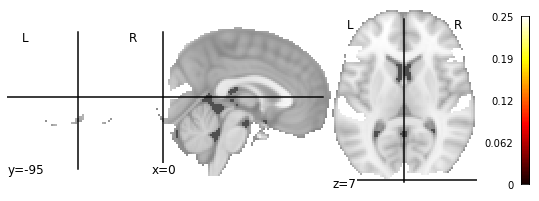

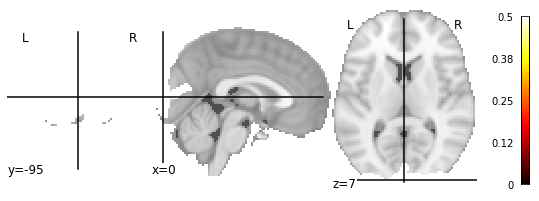

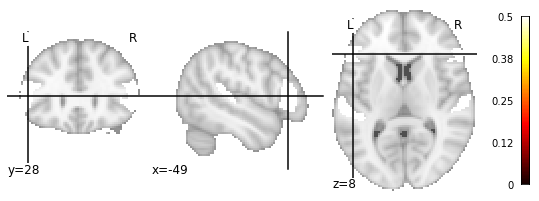

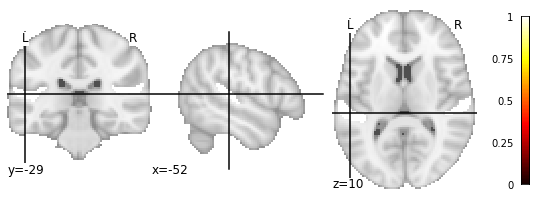

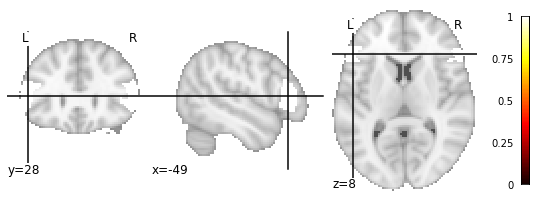

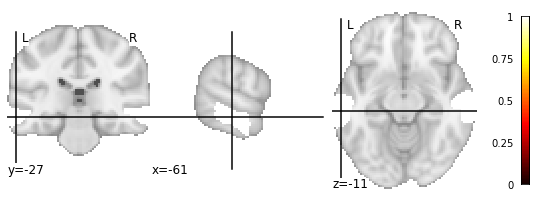

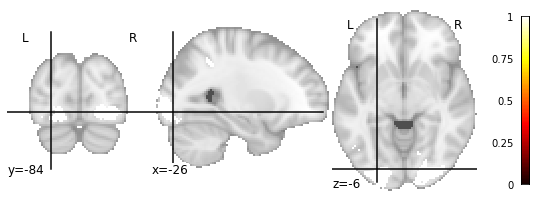

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from nilearn import plotting

from nilearn.input_data import NiftiMasker
from sklearn.model_selection import cross_val_score
import time


for idx, area in enumerate(areas): 
    
    classifiers_data[idx] = {}
    
    print(70 * '_')
    
    # -------------------- MASKER --------------------
    
    # Create masker object to extrach data from beta series.
    area_type=isinstance(area,str)
    if area_type is True: 
        mask=func_mask
        
    # Create img based on atlas mask.
    else:
        mask = mean_img([math_img('img == %d'  %i, img=atlas_filename) for i in area])
    
    masker=NiftiMasker(mask_img=mask, standardize=True)
    # Plot mask.
    plotting.plot_stat_map(mask)
    plotting.show

    X_features=masker.fit_transform(bs_maps)
    
    
    
    # -------------------- TRAIN TEST split --------------------

    # Split the sample to training/test with a 70/30 ratio, and
    # stratify by age class, and also shuffle the data.

    X_train, X_test, y_train, y_test = train_test_split(
                                                        X_features, # x
                                                        classification_target['condition'], # y
                                                        test_size = 0.3, # 70%/30% split  
                                                        shuffle = True, # shuffle dataset
                                                                        # before splitting
                                                        stratify = classification_target['condition'], # keep
                                                                               # distribution
                                                                               # of condtions
                                                                               # consistent
                                                                               # betw. train
                                                                               # & test sets.
                                                        random_state = 123 # same shuffle each
                                                                           # time
                                                                           )

    ## print the size of our training and test groups
    print('number of features:', X_features.shape[1], 'training:', len(X_train), 'testing:', len(X_test))
    
    # -------------------- TRAIN model --------------------

    # Create new classifier model.
    decoder = SVC(kernel=kernel)

    # Initiate timer to determine how long it takes.
    t0 = time.time()
    
    # Train model with the training set.
    decoder.fit(X_train, y_train)

    # Save the area/label/mask used in this iteration.
    classifiers_data[idx]['areas'] = area

    # Save the number of voxels of this mask.
    classifiers_data[idx]['number_voxels'] = X_features.shape[1]
    
    # Save kernel of the SVM classifier.
    classifiers_data[idx]['kernel']=kernel
    
    # Save the Cross-validation results - cv=cv.
    classifiers_data[idx]['train_score_cv'] = cross_val_score(decoder, X_train, y_train, cv=cv, scoring='accuracy')
    
    # Save the Cross-validation results - cv=cv.
    classifiers_data[idx]['train_score'] = decoder.score(X_train, y_train)
    
    # Compare with prediction.
    y_pred = decoder.predict(X_train)
    accuracy = (y_pred == y_train).mean() * 100.
    print(accuracy)

    print("%10s: %.2fs" % (idx, time.time() - t0))
    
    
    # -------------------- TEST model --------------------
    
    classifiers_data[idx]['test_score'] =decoder.score(X_test, y_test)
    print(classifiers_data[idx])
    
    
    

In [25]:
from sklearn.dummy import DummyClassifier

classifier_name='dummy'

# The decoder has as default score the `roc_auc`
d_decoder = DummyClassifier(strategy='uniform')

t0 = time.time()
d_decoder.fit(X_train, y_train)

#classifiers_data[classifier_name] = {}

#classifiers_data[classifier_name]['score'] = 
print(cross_val_score(d_decoder, X_train, y_train, cv=cv, scoring='accuracy'))

#print("%10s: %.2fs" % (classifier_name, time.time() - t0))


# Save the Cross-validation results - cv=cv.
print('Train: ', d_decoder.score(X_train, y_train))

# Compare with prediction.
y_pred = d_decoder.predict(X_train)
accuracy = (y_pred == y_train).mean() * 100.
print(accuracy)



# -------------------- TEST model

print('Test: ', d_decoder.score(X_test, y_test))


   

[0.23502304 0.20737327 0.22580645 0.18981481 0.18981481]
Train:  0.19759926131117267
19.94459833795014
Test:  0.22795698924731184
